In [311]:
import pandas as pd
import numpy as np
from datetime import datetime
from TradingDataFrame import TradingDataFrame
import calendar
from matplotlib import pyplot as plt
import seaborn as sn

In [312]:
class Strategy():
    def __init__(self, name=None):
        self.name = name
    
    def _calculate_daily_pl(self, row):
        pl = 0
        for price, position in zip(price_cols, position_cols):
            pl += row[price] * row[position]
        return pl
        
    def _breakdownQuery(self, query):
        criteria, threshold, sign = '', '', ''
        if len(query.split(' > ')) == 2:
            criteria, threshold = query.split(' > ')
            sign = '>'
        elif len(query.split(' < ')) == 2:
            criteria, threshold = query.split(' < ')
            sign = '<'
        else:
            print('error in query, check again')

        threshold = int(threshold)
        return criteria, sign, threshold

    def _calculatemaxDD(self, df):
        window = len(df)
        roll_max = df['Daily P&L'].cummax()
        daily_dd = df['Daily P&L'] / roll_max - 1
        max_dd = daily_dd.cummin().tolist()[-1]
        return max_dd

    def _count_trades(self, x):
        count = -1
        lst = []
        for ix, i in enumerate(x):
            if ix > 0:
                if i == 1 and x[ix-1] == 1:
                    lst.append(i + count)
                elif i == 1 and x[ix-1] == 0:
                    count += 1
                    lst.append(i + count)
                else:
                    lst.append(i)
            else:
                lst.append(i)
        return pd.Series(lst)

In [313]:
class SimpleStrategy(Strategy):
        
    def set_strategy(self, long_entry, long_exit, short_entry, short_exit):
    
        self.long_entry_criteria, self.long_entry_sign, self.long_entry_threshold = self._breakdownQuery(long_entry)
        self.long_exit_criteria, self.long_exit_sign, self.long_exit_threshold = self._breakdownQuery(long_exit)
        self.short_entry_criteria, self.short_entry_sign, self.short_entry_threshold = self._breakdownQuery(short_entry)
        self.short_exit_criteria, self.short_exit_sign, self.short_exit_threshold = self._breakdownQuery(short_exit)
        
    def apply_strategy(self, tdf):
        if self.long_entry_sign == '>':
            tdf.data.loc[tdf.data[self.long_entry_criteria] > self.long_entry_threshold, 'Position_long'] = 1   
        elif self.long_entry_sign == '<':
            tdf.data.loc[tdf.data[self.long_entry_criteria] < self.long_entry_threshold, 'Position_long'] = 1
        
        if self.long_exit_sign == '>':
            tdf.data.loc[tdf.data[self.long_exit_criteria] > self.long_exit_threshold, 'Position_long'] = 0
        elif self.long_exit_sign == '<':
            tdf.data.loc[tdf.data[self.long_exit_criteria] < self.long_exit_threshold, 'Position_long'] = 0

        if self.short_entry_sign == '>':
            tdf.data.loc[tdf.data[self.short_entry_criteria] > self.short_entry_threshold, 'Position_short'] = 1
        elif self.short_entry_sign == '<':
            tdf.data.loc[tdf.data[self.short_entry_criteria] < self.short_entry_threshold, 'Position_short'] = 1

        if self.short_exit_sign == '>':
            tdf.data.loc[tdf.data[self.short_exit_criteria] > self.short_exit_threshold, 'Position_short'] = 0
        elif self.short_exit_sign == '<':
            tdf.data.loc[tdf.data[self.short_exit_criteria] < self.short_exit_threshold, 'Position_short'] = 0

        tdf.data.fillna(method='ffill', inplace=True)
        tdf.data.fillna(0, inplace=True)

    def backtest(self, tdf, trading_fee=0, check_long=False, check_short=False, check_overall=True):

        # Positions
        df_backtest = tdf.data.reset_index().copy()
        df_backtest['long_count'] = self._count_trades(df_backtest['Position_long'])
        df_backtest['short_count'] = self._count_trades(df_backtest['Position_short'])

        # P&L
        df_backtest['Change position'] = (df_backtest['Position_long'].diff() != 0)\
                                                |(df_backtest['Position_short'].diff() != 0)
        df_backtest['Daily P&L'] = (df_backtest['Position_long'].shift()\
                                    - df_backtest['Position_short'].shift())\
                                    * df_backtest[tdf.price_cols[0]+'_pct_change']\
                                    - df_backtest['Change position'] * trading_fee
        df_backtest['Cumulative P&L'] = np.exp(np.log1p(df_backtest['Daily P&L']).cumsum()) - 1
        df_backtest = df_backtest.iloc[1:,:]

        # General metrics
        long_count = max(df_backtest['long_count'])
        short_count = max(df_backtest['short_count'])
        total_count = long_count + short_count
        max_dd = self._calculatemaxDD(df_backtest)
        self.df_backtest = df_backtest
        
        sharpe_ratio = np.sqrt(len(df_backtest)) * np.mean(df_backtest['Daily P&L']) / np.std(df_backtest['Daily P&L'])

        # Trade metrics
        df_long_profit = df_backtest.groupby('long_count').sum(numeric_only=True)
        df_long_profit = df_long_profit[df_long_profit.index != 0]      # Exclude out of position counts

        if (np.exp(np.log1p(df_long_profit[tdf.price_cols[0]+'_pct_change']).cumsum()) - 1).tolist() == []:
            print('No long txs made.')
            total_long_profit, mean_long_profit, max_long_profit = 0, 0, 0
        else:
            total_long_profit = (np.exp(np.log1p(df_long_profit[tdf.price_cols[0]+'_pct_change']).cumsum()) - 1).tolist()[-1]
            mean_long_profit = df_long_profit[tdf.price_cols[0]+'_pct_change'].mean()
            max_long_profit = df_long_profit[tdf.price_cols[0]+'_pct_change'].max()

        df_short_profit = df_backtest.groupby('short_count').sum(numeric_only=True)
        df_short_profit = df_short_profit[df_short_profit.index != 0]      # Exclude out of position counts
        
        if (np.exp(np.log1p(df_short_profit[tdf.price_cols[0]+'_pct_change']).cumsum()) - 1).tolist() == []:
            print('No short txs made.')
            total_short_profit, mean_short_profit, max_short_profit = 0, 0, 0
        else:
            total_short_profit = (np.exp(np.log1p(df_short_profit[tdf.price_cols[0]+'_pct_change']).cumsum()) - 1).tolist()[-1]
            mean_short_profit = df_short_profit[tdf.price_cols[0]+'_pct_change'].mean()
            max_short_profit = df_short_profit[tdf.price_cols[0]+'_pct_change'].max()

        # Outputs

        if check_long:
            print(f'For long trades...:')
            print(f'# of trades: {long_count}')
            print(f'Total profit: {round(total_long_profit*100,2)}%')
            print(f'Mean profit: {round(mean_long_profit*100,2)}%')
            print(f'Max profit in a trade: {round(max_long_profit*100,2)}%')
            print('...')

        if check_short:
            print(f'For short trades...:')
            print(f'# of trades: {short_count}')
            print(f'Total profit: {round(total_short_profit*100,2)}%')
            print(f'Mean profit: {round(mean_short_profit*100,2)}%')
            print(f'Max profit in a trade: {round(max_short_profit*100,2)}%')
            print('...')

        if check_overall:
            print('Overall:')
            print(f'# of trades: {total_count}')
            print(f'Total profit: {round((total_long_profit + total_short_profit)*100,2)}%')
            print(f'Max profit in a trade: {round(max(max_long_profit, max_short_profit)*100,2)}%')
            print(f'Sharpe ratio: {round(sharpe_ratio,2)}')
            print(f'Max Drawdown: {round(max_dd)}%')

        df_backtest.set_index(tdf.time_col, inplace=True)
        plt.xticks(rotation=45)
        sn.lineplot(df_backtest['Cumulative P&L'])

In [314]:
# Binance packages

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from binance.exceptions import BinanceAPIException

api_key = 'uD7GhqYsUvfhpM3KDSAsqKXsXD3fVtvzdICbDEPPpSMMG4dQIFq532ETpUy98aud'
api_secret = 'nWdUsoGfUYXH7TzuNqio0W9O6ADOSezLCIJ9V6dvMS6wYqN2I0prvAeLxNF53yl2'
client = Client(api_key, api_secret)
prices = pd.DataFrame(client.get_all_tickers())

today_date = str(datetime.today().day+1) + ' ' + calendar.month_abbr[datetime.today().month] + ' ' + str(datetime.today().year)

# Extract BTCUSDT data

klines = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_1HOUR, '16 Jan 2023', today_date)
klines_cols = [
    'Open Time',
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Close time',
    'Quote asset volume',
    'Number of trades',
    'Taker buy base asset volume',
    'Taker buy quote asset volume',
    'Ignore']

# Setup df

df = pd.DataFrame(klines, columns=klines_cols)
df.drop_duplicates(inplace=True)

In [315]:
tdf.data

,Open,Number of trades,Open_pct_change,Position_long,Position_short
Open Time,,,,,
2023-01-16 01:00:00,20966.58,465451,0.004484,1.0,0.0
2023-01-16 02:00:00,21182.87,406459,0.010316,1.0,0.0
2023-01-16 03:00:00,21208.54,311744,0.001212,1.0,0.0
2023-01-16 04:00:00,21074.80,228631,-0.006306,0.0,0.0
2023-01-16 05:00:00,21147.98,212925,0.003472,0.0,0.0
...,...,...,...,...,...
2023-02-12 06:00:00,21799.50,145593,0.000759,0.0,0.0
2023-02-12 07:00:00,21809.77,133555,0.000471,0.0,0.0
2023-02-12 08:00:00,21798.42,159867,-0.000520,0.0,0.0


No short txs made.
Overall:
# of trades: 43.0
Total profit: 1.72%
Max profit in a trade: 6.99%
Sharpe ratio: -0.0
Max Drawdown: -3%


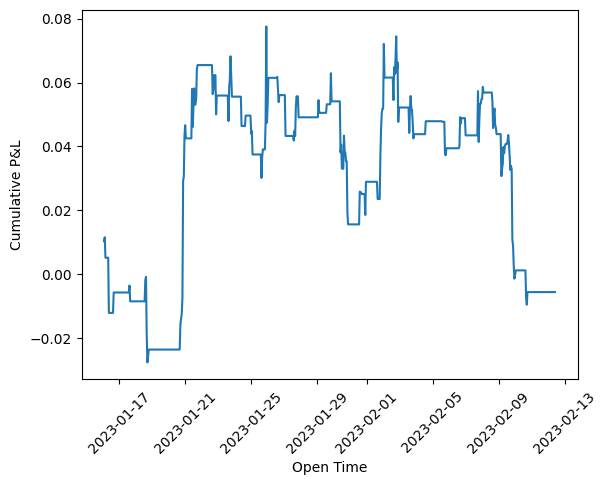

In [316]:
# Data preprocessing
price_cols = ['Open']
criteria_cols = ['Number of trades']
tdf = TradingDataFrame(df, time_col='Open Time', price_cols=price_cols, criteria_cols=criteria_cols, source='binance')

nlp = SimpleStrategy('sentiment_analysis_ML')
nlp.set_strategy(
    long_entry='Number of trades > 400000',
    long_exit='Number of trades < 300000',
    short_entry='Number of trades < 100000',
    short_exit='Number of trades > 200000'
)
nlp.apply_strategy(tdf)
nlp.backtest(tdf)